<a href="https://colab.research.google.com/github/WesselBoi/Suicidal-Content-detection/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -qqq emoji fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 15.6 MB/s eta 0:00:00


In [ ]:
# Import packages
import os
import pandas as pd
import numpy as np
import itertools
import collections
import networkx as nx
import six
import matplotlib.pyplot as plt
import seaborn as sns
import emoji as em
import fasttext

from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split

import nltk
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Change to your own directory
try:
    os.chdir("/content/drive/MyDrive/SuicideModel")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Directory changed


In [ ]:
# Set constants
SEED = 4222

In [ ]:
# Load dataset
df = pd.read_csv('Data/Suicide_Detection.csv', index_col=0)
df.reset_index(drop=True, inplace=True)
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
# Check for null values
df.isnull().sum()

,0
text,0
class,0


class
suicide        116037
non-suicide    116037
Name: count, dtype: int64
class
suicide        0.5
non-suicide    0.5
Name: proportion, dtype: float64


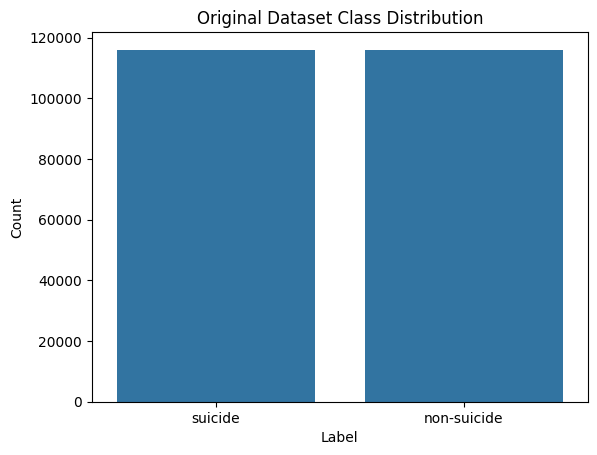

In [ ]:
# Check class distribution
print(df['class'].value_counts())
print(df['class'].value_counts(normalize=True))

sns.countplot(x=df['class'])
plt.title('Original Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [ ]:
# Check lowercase
lowercase = df['text'].str.islower()
print(lowercase.value_counts())

# df['text'][lowercase == True]

text
False    214395
True      17679
Name: count, dtype: int64


In [ ]:
# Check extra whitespace
extra_whitespace = df['text'].str.match('\s\s+')
print(extra_whitespace.value_counts())

# df['text'][extra_whitespace == True]

text
False    232073
True          1
Name: count, dtype: int64


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3571346012.py:2: SyntaxWarning: invalid escape sequence '\s'
  extra_whitespace = df['text'].str.match('\s\s+')


In [ ]:
# Check URL
url = df['text'].str.contains("http")
print(url.value_counts())

# df['text'][url == True]

text
False    224921
True       7153
Name: count, dtype: int64


In [ ]:
# Check mentions
mention = df['text'].str.match('@(\w+)')
print(mention.value_counts())

# df['text'][mention == True]

text
False    232072
True          2
Name: count, dtype: int64


<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3752938018.py:2: SyntaxWarning: invalid escape sequence '\w'
  mention = df['text'].str.match('@(\w+)')


In [ ]:
# Check hashtags
hashtag = df['text'].str.match('#(\w+)')
print(hashtag.value_counts())

# df['text'][hashtag == True]

text
False    232061
True         13
Name: count, dtype: int64


<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-2951656274.py:2: SyntaxWarning: invalid escape sequence '\w'
  hashtag = df['text'].str.match('#(\w+)')


In [ ]:
# Check subreddit tag
subreddit = df['text'].str.match('r/(\w+)')
print(subreddit.value_counts())

# df['text'][subreddit == True]

text
False    231990
True         84
Name: count, dtype: int64


<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-2250397923.py:2: SyntaxWarning: invalid escape sequence '\w'
  subreddit = df['text'].str.match('r/(\w+)')


In [ ]:
# Check users tag
users = df['text'].str.match('u/(\w+)')
print(users.value_counts())

# df['text'][users == True]

text
False    231859
True        215
Name: count, dtype: int64


<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-2153490989.py:2: SyntaxWarning: invalid escape sequence '\w'
  users = df['text'].str.match('u/(\w+)')


In [ ]:
# Check special characters
special_characters = df['text'].str.match('[^0-9a-zA-Z]+')
print(special_characters.value_counts())

# df['text'][special_characters == True]

text
False    229638
True       2436
Name: count, dtype: int64


In [ ]:
import emoji

def text_has_emoji(text):
    for character in text:
        if emoji.is_emoji(character):  # for modern emoji library
            return True
    return False

emoji_mask = df['text'].apply(text_has_emoji)
print(emoji_mask.value_counts())


text
False    221956
True      10118
Name: count, dtype: int64


In [ ]:
import emoji

def count_emojis(text):
    return sum(c in emoji.EMOJI_DATA for c in text)

emoji_counts = df['text'].apply(count_emojis)
print(emoji_counts.value_counts())

# df['text'][emoji_counts > 0]


text
0      221956
1        5086
2        1924
3        1102
4         519
        ...  
68          1
835         1
108         1
385         1
131         1
Name: count, Length: 160, dtype: int64


In [ ]:
# Check language
!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

PRETRAINED_FASTTEXT_PATH = '/tmp/lid.176.bin'
model = fasttext.load_model(PRETRAINED_FASTTEXT_PATH)

def check_language(text):
  sentences = text.split("\n")
  predictions = model.predict(sentences)
  language = predictions[0][0][0].split("__label__")[1]
  confidence = predictions[1][0][0]

  return language

language = df['text'].apply(check_language)
print(language.value_counts())

# df['text'][language != 'en']

--2025-10-14 16:20:07--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125.18M   336MB/s    in 0.4s    

2025-10-14 16:20:07 (336 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]

text
en     229334
de        596
ca        362
ja        353
si        166
        ...  
mn          1
hy          1
ceb         1
hsb         1
bg          1
Name: count, Length: 90, dtype: int64


## Cleaned Dataset

In [ ]:
# Load dataset
clean_df = pd.read_csv('Data/suicide_detection_final_cleaned.csv', header=0)
clean_df

,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl fee...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally hear bad year swear fuck god annoying
3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,It ends tonight.I can’t do it anymore. \nI quit.,suicide,end tonight not anymore quit
...,...,...,...
174847,I did something today I went sledding with my ...,non-suicide,today go sled friend not like pretty big miles...
174848,If you don't like rock then your not going to ...,non-suicide,not like rock not go
174849,You how you can tell i have so many friends an...,non-suicide,tell friend not lonely deprive buy little nigh...
174850,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably taste like salty tea drink pee co...


In [ ]:
# Check for null values
clean_df.isnull().sum()

,0
text,0
class,0
cleaned_text,1


In [ ]:
# Split dataset into train and test sets
train_data, test_data = train_test_split(clean_df,
                                         test_size=0.2,
                                         random_state=SEED,
                                         stratify=clean_df['class'])

In [ ]:
# Split train set into classes
train_data_suicidal = train_data[train_data['class'] == "suicide"]
train_data_nonsuicidal = train_data[train_data['class'] == "non-suicide"]

### Full dataset

class
non-suicide    107216
suicide         67636
Name: count, dtype: int64
class
non-suicide    0.613181
suicide        0.386819
Name: proportion, dtype: float64


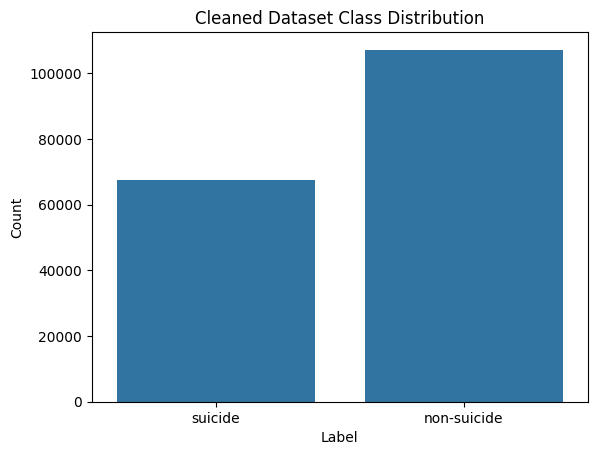

In [ ]:
# Check class distribution
print(clean_df['class'].value_counts())
print(clean_df['class'].value_counts(normalize=True))

sns.countplot(x=clean_df['class'])
plt.title('Cleaned Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Train dataset

class
non-suicide    85772
suicide        54109
Name: count, dtype: int64
class
non-suicide    0.613178
suicide        0.386822
Name: proportion, dtype: float64


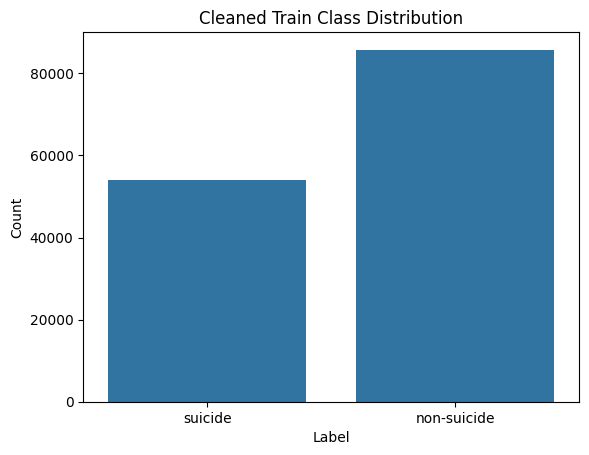

In [ ]:
# Check class distribution
print(train_data['class'].value_counts())
print(train_data['class'].value_counts(normalize=True))

sns.countplot(x=train_data['class'])
plt.title('Cleaned Train Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

## Suicidal Text

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_suicidal['cleaned_text'])

In [ ]:
tokenizer.word_counts.items()

odict_items([('not', 107763), ('love', 6796), ('need', 9027), ('survive', 808), ('die', 14324), ('self', 2753), ('improvement', 66), ('recognise', 17), ('want', 40441), ('right', 6352), ('relapse', 197), ('fear', 1002), ('person', 4110), ('abandon', 278), ('plus', 299), ('no', 19751), ('know', 25442), ('deserve', 1948), ('hate', 7408), ('get', 10335), ('life', 23843), ('fall', 1457), ('like', 23759), ('waste', 1409), ('time', 14043), ('money', 1671), ('energy', 593), ('dream', 1017), ('place', 2423), ('wish', 5463), ('pain', 5418), ('friend', 12000), ('family', 6793), ('feel', 29968), ('infinitely', 15), ('well', 7572), ('recently', 1273), ('start', 3694), ('think', 18785), ('suicide', 10219), ('work', 6159), ('bad', 9147), ('guess', 2068), ('certain', 311), ('ready', 1690), ('terrify', 251), ('go', 19855), ('lose', 4333), ('job', 3697), ('okay', 1285), ('ruin', 1135), ('broke', 111), ('lonely', 1445), ('unqualified', 3), ('bright', 121), ('tomorrow', 1658), ('people', 13356), ('thing'

In [ ]:
word_freq_suicidal = pd.DataFrame(tokenizer.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)

### Word Frequency Bar Graph

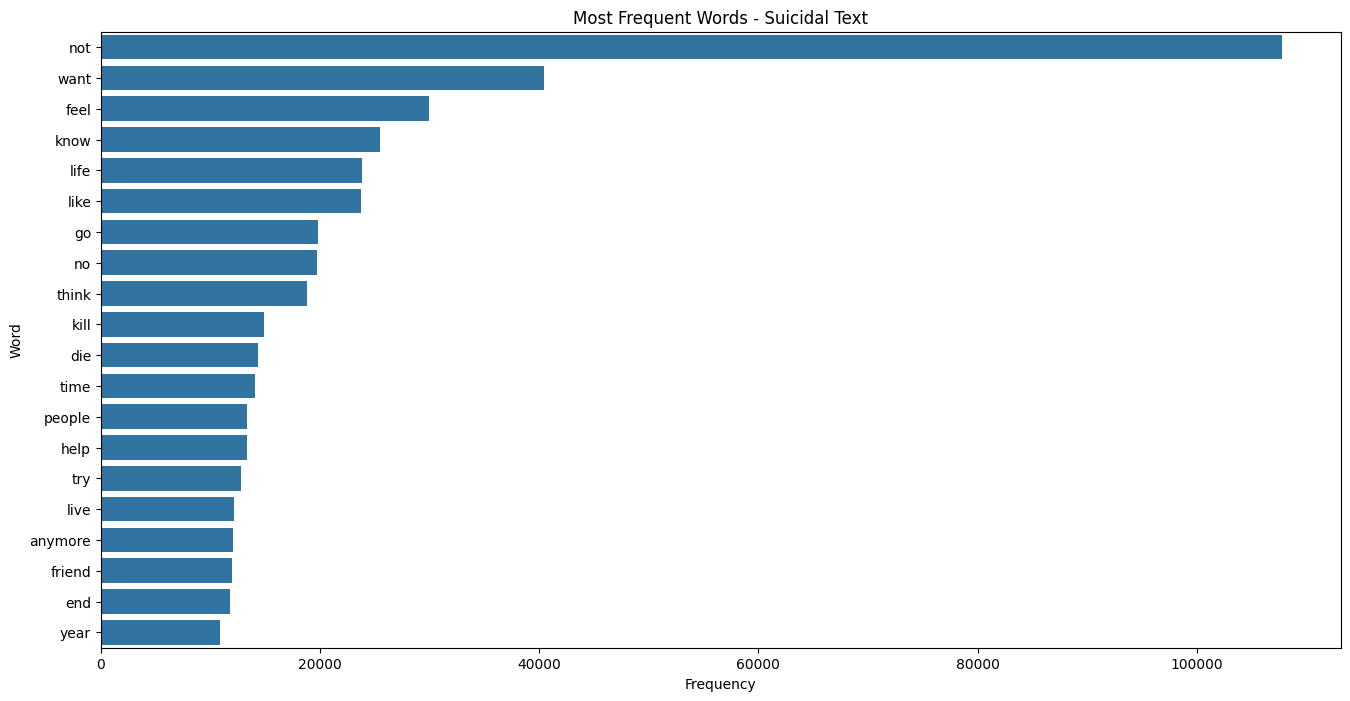

In [ ]:
# Word Frequency Bar Graph
plt.figure(figsize=(16, 8))
sns.barplot(x='count',y='word',data=word_freq_suicidal.iloc[:20])
plt.title('Most Frequent Words - Suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

### Wordcloud

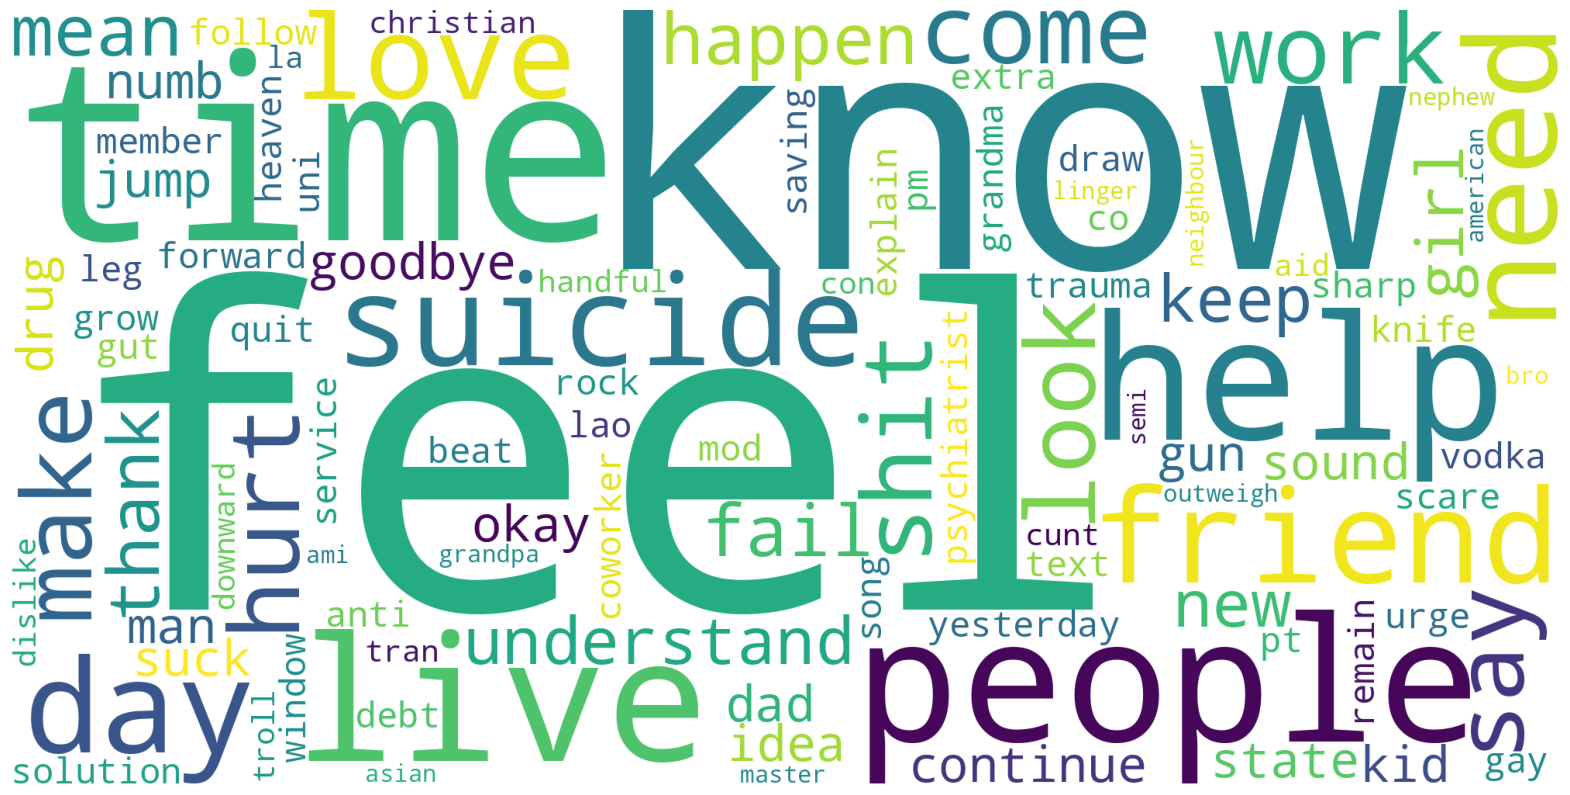

In [ ]:
# Wordcloud
feature_names=word_freq_suicidal['word'].values
wc=WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

#Non-Suicidal Text


In [ ]:
tokenizer_nonsuicidal = Tokenizer()
tokenizer_nonsuicidal.fit_on_texts(train_data_nonsuicidal["text"])

In [ ]:
tokenizer_nonsuicidal.word_counts.items()

odict_items([('i', 148036), ('passed', 256), ('my', 55977), ('driving', 243), ('theory', 107), ('test', 1110), ('that’s', 1655), ('all', 12678), ('really', 9166), ('i’m', 13729), ('just', 29215), ('quite', 485), ('happy', 2843), ('about', 13573), ('it', 51076), ('gamer', 172), ('girls', 2781), ('rise', 74), ('up', 10296), ('it’s', 6152), ('so', 29859), ('horrible', 326), ('that', 30091), ('because', 8720), ('you’re', 1268), ('a', 80345), ('chick', 66), ('and', 86993), ('you', 41786), ('play', 2881), ('destiny', 43), ('minecraft', 1183), ('guys', 6443), ('suddenly', 245), ('want', 11327), ('fuk', 17), ('like', 26889), ('no', 8248), ('more', 5082), ('creepy', 213), ('dms', 393), ('please', 4574), ('i‘m', 18), ('pretending', 83), ('everything', 1912), ('is', 37076), ('fine', 795), ('but', 27999), ('isn’t', 675), ('was', 18164), ('going', 5081), ('to', 89341), ('do', 20354), ('some', 9233), ('homework', 675), ('searched', 61), ('for', 29615), ('relaxing', 52), ('study', 444), ('music', 166

In [ ]:
word_freq_nonsuicidal = pd.DataFrame(tokenizer_nonsuicidal.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
word_freq_nonsuicidal.head()

,word,count
0,i,148036
51,to,89341
27,and,86993
25,a,80345
74,the,74267


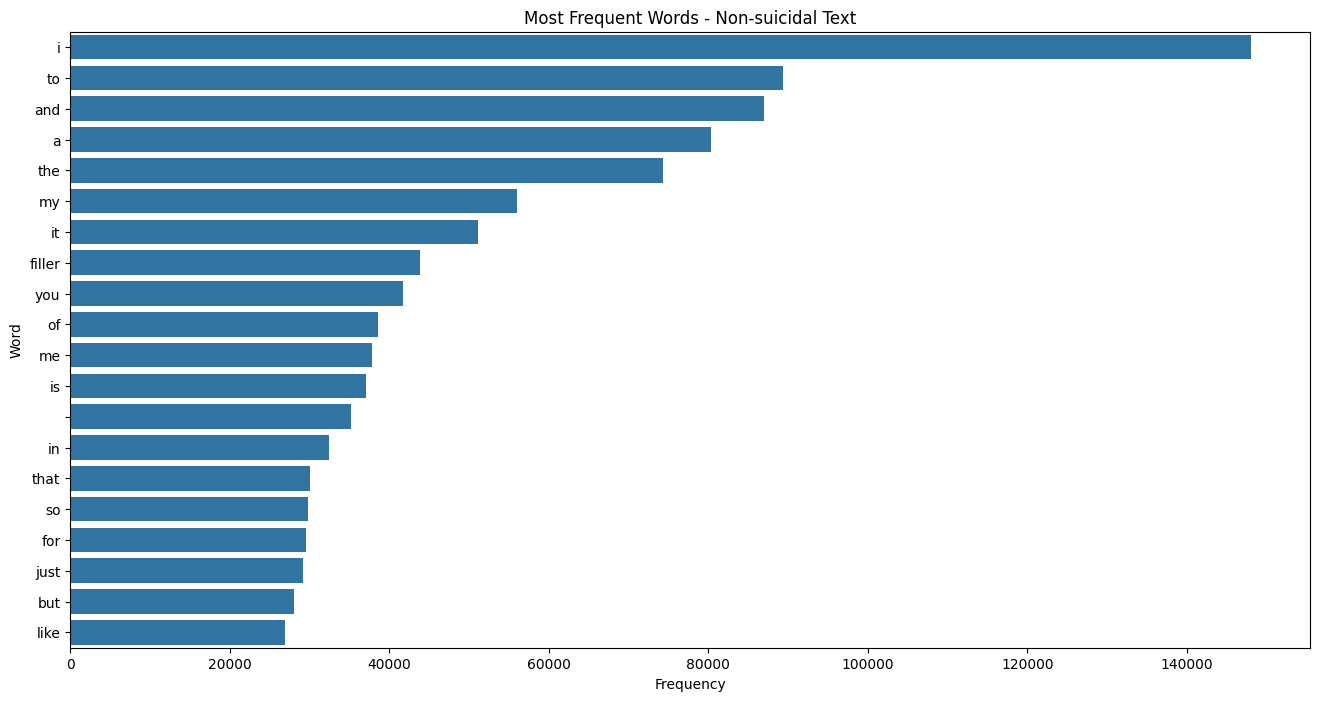

In [ ]:
# Word Frequency Bar Graph
plt.figure(figsize=(16, 8))
sns.barplot(x='count', y='word', data=word_freq_nonsuicidal.iloc[:20])
plt.title('Most Frequent Words - Non-suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

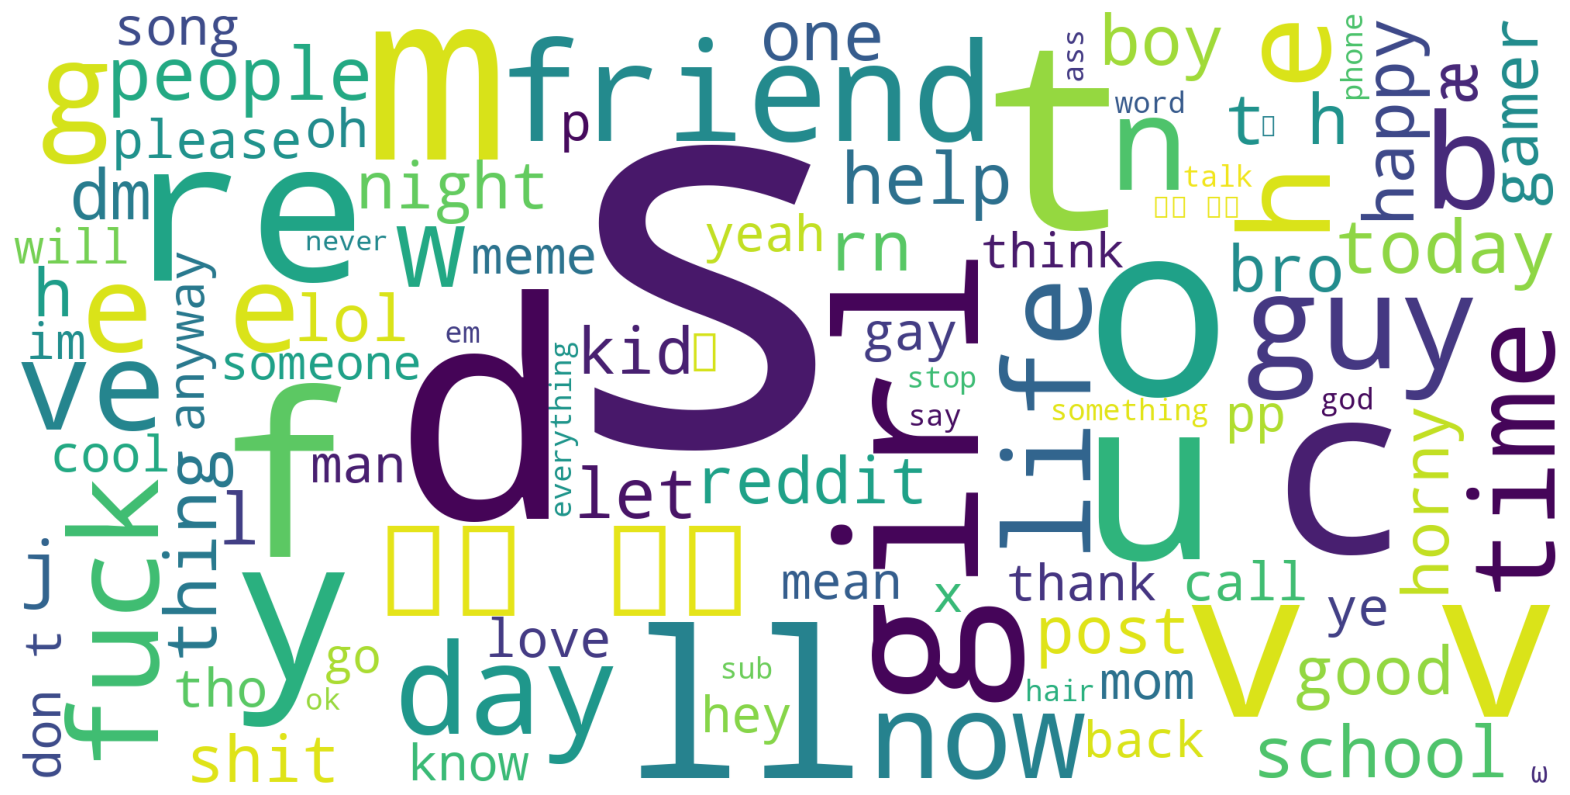

In [ ]:
# Wordcloud
feature_names_nonsuicidal = word_freq_nonsuicidal['word'].values
wc = WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names_nonsuicidal))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()